# Understanding Neural Networks

### Setup Environment

In [165]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# native
import os
from os import listdir
from collections import defaultdict
from PIL import Image
import pprint as pp
import functools
import pickle
import re

# math
import numpy as np
from sklearn.metrics import accuracy_score

# plotting
import matplotlib
from matplotlib import pyplot as plt

# extra
from tqdm import tqdm

# pytorch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models


#### Check Environment

In [166]:
requirements = {
    torch: '1',
    matplotlib: '3'
}

def check_requirements(requirements):
    for requirement in requirements:
        error_message = '{} environment does not match requirement'.format(requirement.__name__)
        assert (requirement.__version__[0] == requirements[requirement]), error_message

check_requirements(requirements)

#### Check CUDA

In [167]:
cuda = torch.cuda.is_available()

if cuda:
    torch.backends.cudnn.benchmark = True
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = 'cuda' if cuda else 'cpu'

device

'cuda'

### Useful Functions

In [168]:
class PlotGrid:
    def __init__(self, figsize=None):
        self.fig = plt.figure(figsize=figsize)
        self.ax = {}
        self.xlim = {}
        self.ylim = {}
        self.filled = {}
        self.grid = {}
    
    def plot(self, position_id, data, title=None, xlim=None, ylim=None, filled=None, grid=None):
        if position_id in self.ax:
            ax = self.ax[position_id]
        else:
            ax = self.fig.add_subplot(*position_id)

        # cache current values
        if title is None:
            title = ax.get_title()

        if xlim is not None:
            self.xlim[position_id] = xlim

        if ylim is not None:
            self.ylim[position_id] = ylim

        if filled is not None:
            self.filled[position_id] = filled
        
        if position_id not in self.filled:
            self.filled[position_id] = True

        if grid is not None:
            self.grid[position_id] = grid
        
        if position_id not in self.grid:
            self.grid[position_id] = True

        ax.cla()
        ax.clear()
        if type(data).__name__ == 'Image':
            ax.imshow(data)
        else:
            if hasattr(data, 'is_cuda') and data.is_cuda:
                data = data.cpu()
            if hasattr(data, 'numpy'):
                data = data.numpy()
            ax.plot(data)

            if self.filled[position_id]:
                ax.fill_between(range(len(data)), data)

            if self.grid[position_id]:
                ax.grid(True)

            # set xlim
            if position_id in self.xlim:
                ax.set_xlim(*self.xlim[position_id])

            # set ylim
            if position_id in self.ylim:
                ax.set_ylim(*self.ylim[position_id])
        
        # set title
        if title is not None:
            ax.set_title(title)

        self.fig.tight_layout()
        self.fig.canvas.draw()
        self.ax[position_id] = ax
    
    def prediction_plot(self, position_id, data, title=None, grid=None):
        if position_id in self.ax:
            ax = self.ax[position_id]
        else:
            ax = self.fig.add_subplot(*position_id)

        # cache current values
        if title is None:
            title = ax.get_title()

        if grid is not None:
            self.grid[position_id] = grid
        
        if position_id not in self.grid:
            self.grid[position_id] = True

        ax.cla()
        ax.clear()
        plot_data = data[2]
        plot_labels = data[1]
        if hasattr(plot_data, 'is_cuda') and plot_data.is_cuda:
            plot_data = plot_data.cpu()
        if hasattr(plot_data, 'numpy'):
            plot_data = plot_data.numpy()

        ticks = range(len(plot_data)-1, -1, -1)

        ax.barh(ticks, plot_data, align='center')

        if self.grid[position_id]:
            ax.grid(True)

        # set xlim
        ax.set_xlim(0, 1)

        # set y labels
        ax.set_yticks(ticks)
        ax.set_yticklabels(plot_labels)
        
        # set title
        if title is not None:
            ax.set_title(title)

        self.fig.tight_layout()
        self.fig.canvas.draw()
        self.ax[position_id] = ax
    
    def savefig(self, filename):
        figure_directory = os.path.join('results', 'activation-plots')
        os.makedirs(figure_directory, exist_ok=True)
        figure_path = os.path.join(figure_directory, filename)
        self.fig.savefig(figure_path, bbox_inches='tight')


#### Test PlotGrid

<IPython.core.display.Javascript object>


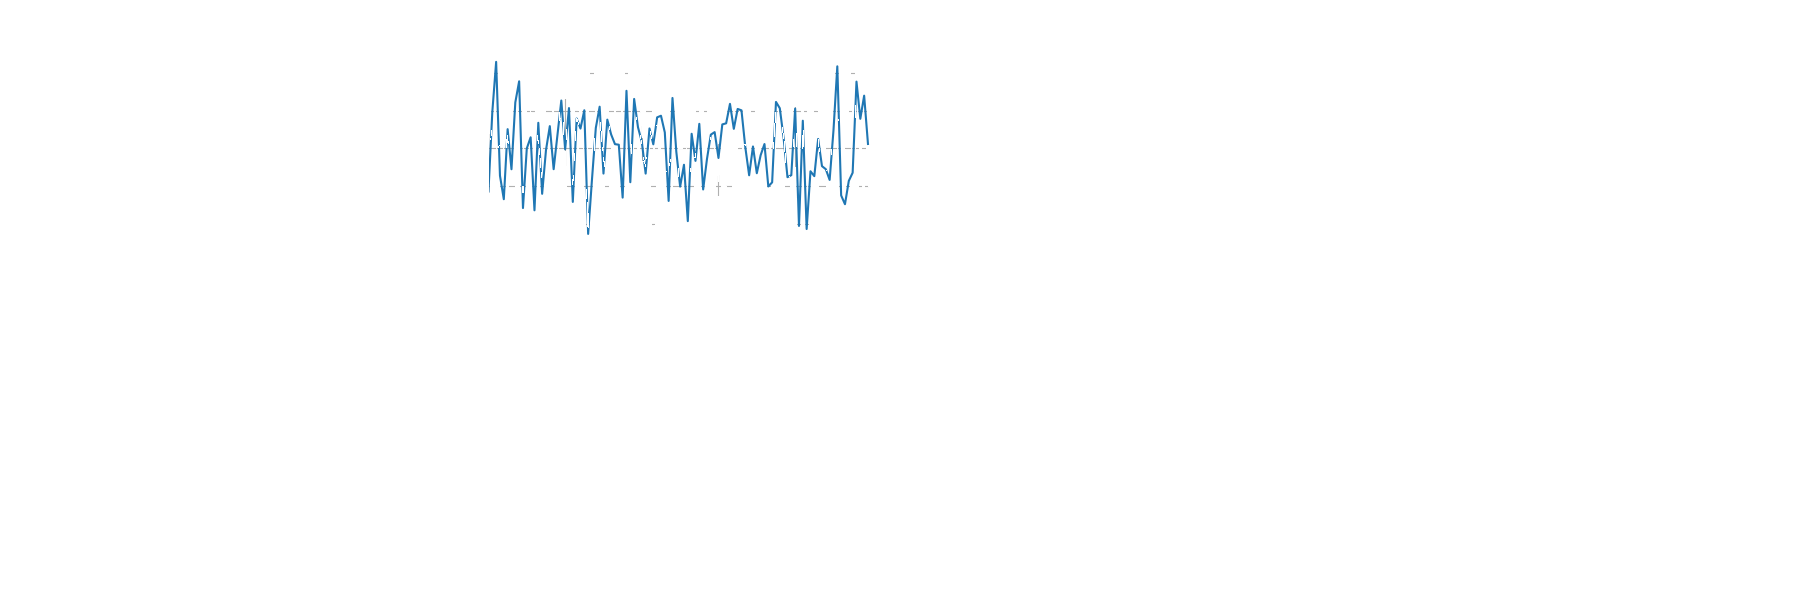

In [169]:
# test plotting function
plot_grid = PlotGrid(figsize=(9,3))

# initialize figures
# random
data = torch.rand((100))
plot_grid.plot((1, 2, 1), data, title='Random', xlim=(0, len(data)), ylim=(0.0, 1.0))
# normal
data = torch.randn((100))
plot_grid.plot((1, 2, 2), data, title='Normal', xlim=(0, len(data)), ylim=(-3.0, 3.0), filled=False)


In [170]:
# update plots
for i in range(10):
    # random
    data = torch.rand((100))
    plot_grid.plot((1, 2, 1), data)
    # normal
    data = torch.randn((100))
    plot_grid.plot((1, 2, 2), data)


In [7]:
def pathJoin(*args):
    return os.path.abspath(os.path.join(*args))


def pprint(*args):
    pp.pprint(*args)


def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))


toPILImage = transforms.ToPILImage()

softmax = torch.nn.Softmax(dim=1)


def predict(model, dataset, idx, grid, position):
    datapoint = dataset[idx]
    image = datapoint[1].unsqueeze(0).to(device)
    
    # convert to probabilities
    with torch.no_grad():
        output = softmax(model(image))
    
    # top 1
    prediction_probability, predicted_class = output.topk(1, 1, True, True)
    prediction_probability = prediction_probability.squeeze()
    predicted_class = predicted_class.squeeze()
    predicted_description = dataset.descriptions[predicted_class]
    top_1 = (predicted_class, predicted_description, prediction_probability)

    # top 5
    prediction_probability_5, predicted_class_5 = output.topk(5, 1, True, True)
    prediction_probability_5 = prediction_probability_5.squeeze()
    predicted_class_5 = predicted_class_5.squeeze()
    predicted_description_5 = [dataset.descriptions[predicted_class] for predicted_class in predicted_class_5]
    top_5 = (predicted_class_5, predicted_description_5, prediction_probability_5)

    # all
    prediction_probability_all, predicted_class_all = output.topk(output.shape[1], 1, True, True)
    prediction_probability_all = prediction_probability_all.squeeze()
    predicted_class_all = predicted_class_all.squeeze()
    predicted_description_all = [dataset.descriptions[predicted_class] for predicted_class in predicted_class_all]
    top_all = (predicted_class_all, predicted_description_all, prediction_probability_all)

    if position is not None:
        if grid is None:
            plt.subplot(*position)
            plt.imshow(toImage(datapoint[1]))
            plt.title('True: {}\n Predicted: {}'.format(datapoint[3], predicted_description))
        else:
            grid.plot(position, toImage(datapoint[1]), title='True: {}'.format(datapoint[3]))
            prediction_plot_position = (position[0], position[1], position[2] + 1)
            grid.prediction_plot(prediction_plot_position, top_5, title='Predicted: {}'.format(predicted_description))
    return (top_1, top_5, top_all)


#### Load Dataset - CIFAR10

In [8]:
cifar10_dataset_path = os.path.join('datasets', 'cifar10')

cifar10_transforms = transforms.Compose([
    transforms.ToTensor()
])

cifar10_train_dataset = datasets.CIFAR10(cifar10_dataset_path,
                                         train=True,
                                         download=True,
                                         transform=cifar10_transforms)

cifar10_test_dataset = datasets.CIFAR10(cifar10_dataset_path,
                                         train=False,
                                         download=True,
                                         transform=cifar10_transforms)

cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_dataset,
                                                   batch_size=64,
                                                   shuffle=True,
                                                   num_workers=1)

cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_dataset,
                                                   batch_size=64,
                                                   shuffle=False,
                                                   num_workers=1)


Files already downloaded and verified
Files already downloaded and verified


#### Load Dataset - ImageNet

In [9]:
class BaseDataset(Dataset):

    def __init__(self, directory, split='train', transforms=None):
        self.datapoints = defaultdict(list)
        self.split = split
        self.directory = pathJoin(directory, split)
        self.datapoints = self.loadDataset()
        self.transforms = transforms

    def __len__(self):
        return len(self.datapoints)

    def __getitem__(self, idx):
        datapoint = self.loadDatapoint(idx)
        return datapoint

    def loadDatapoint(self, idx):
        raise NotImplementedError('Function "loadDatapoint" is not implemented')

    def loadDataset(self, name):
        raise NotImplementedError('Function "loadDataset" is not implemented')


In [10]:
class ImageNetDataset(BaseDataset):

    def __init__(self, directory, split='train', transforms=None):
        super().__init__(directory, split, transforms)
        self.descriptions = self.loadDescriptions()
        self.classes = self.loadClasses()
        self.groundtruths = self.loadValidationGroundtruths() if split == 'val' else []

    def loadDatapoint(self, idx):
        filepath = self.datapoints[idx]
        image = Image.open(filepath).convert('RGB')
        if self.split == 'val':
            groundtruth = self.groundtruths[idx]
        elif self.split == 'train':
            groundtruth = self.classes.index(filepath.split('/').pop().split('_')[0])
        if self.transforms:
            image = self.transforms(image)
        return (filepath, image, groundtruth, self.descriptions[groundtruth])

    def loadDataset(self):
        datapoints = []

        dataset_file_list_filename = 'ilsvrc2012{}.txt'.format(self.split)
        dataset_file_list_path = os.path.join(self.directory, dataset_file_list_filename)

        with open(dataset_file_list_path, 'r') as dataset_file_list_file:
            for line in tqdm(dataset_file_list_file, total=sum(1 for line in open(dataset_file_list_path))):
                file_path = pathJoin(self.directory, self.sanitizeFilename(line))
                datapoints.append(file_path)
        
        return datapoints
    
    def sanitizeFilename(self, filename):
        return filename.replace('"', '').strip()

    def loadDescriptions(self):
        descriptions = []

        descriptions_filename = 'synsets_with_descriptions.txt'
        descriptions_path = pathJoin(self.directory, '..', descriptions_filename)

        with open(descriptions_path, 'r') as descriptions_file:
            for line in descriptions_file:
                description_breakdown = line.split(' ')
                description_breakdown.pop(0)
                description = ' '.join(description_breakdown).strip()
                descriptions.append(description)

        return descriptions

    def loadValidationGroundtruths(self):
        groundtruths = []

        groundtruths_filename = 'validation_ground_truth.txt'
        groundtruths_path = pathJoin(self.directory, '..', groundtruths_filename)

        with open(groundtruths_path, 'r') as groundtruths_file:
            for line in groundtruths_file:
                groundtruth_breakdown = line.split(' ')
                groundtruth_breakdown.pop(0)
                groundtruth = ' '.join(groundtruth_breakdown).strip()
                groundtruths.append(int(groundtruth))

        return groundtruths

    def loadClasses(self):
        classes = []

        classes_filename = 'synsets.txt'
        classes_path = pathJoin(self.directory, '..', classes_filename)

        with open(classes_path, 'r') as classes_file:
            for line in classes_file:
                classes.append(line.strip())

        return classes


### Function to visualize images

In [131]:
class DeNormalize(object):
    # Source: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = image.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


In [132]:
BATCH_SIZE = 64

imagenet_normalization_values = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

normalize = transforms.Normalize(**imagenet_normalization_values)
denormalize = DeNormalize(**imagenet_normalization_values)


def toImage(tensor_image):
    return toPILImage(denormalize(tensor_image))

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

imagenet_dataset_path = os.path.join('datasets', 'imagenet')

# imagenet_train_dataset = ImageNetDataset(imagenet_dataset_path, transforms=test_transforms)
imagenet_val_dataset = ImageNetDataset(imagenet_dataset_path, split='val', transforms=test_transforms)
# imagenet_test_dataset = ImageNetDataset(imagenet_dataset_path, split='test')

# imagenet_train_loader = DataLoader(imagenet_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
imagenet_val_loader = DataLoader(imagenet_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# imagenet_test_loader = DataLoader(imagenet_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 50000/50000 [00:01<00:00, 27322.02it/s]


#### View Image(s)

<IPython.core.display.Javascript object>


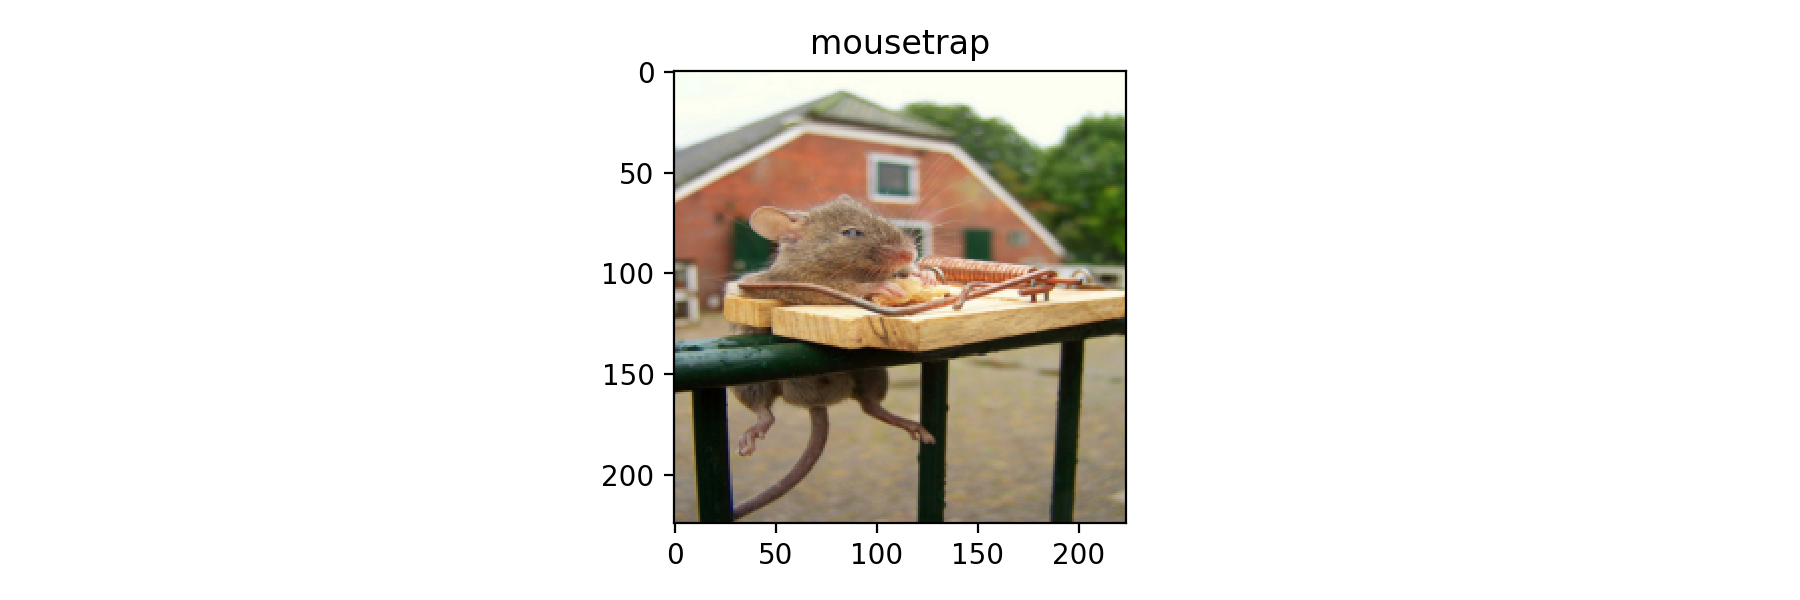

In [133]:
image_grid = PlotGrid(figsize=(9,3))

In [134]:
for index, image in enumerate(imagenet_val_dataset):
    img = image[1]
    image_grid.plot((1, 1, 1), toImage(img), title=image[3])
    if (index + 1) == 9:
        break

#### Load Model

In [15]:
resnet50 = models.resnet50(pretrained=True)
resnet50.eval();

#### Check Validation Performance

<IPython.core.display.Javascript object>


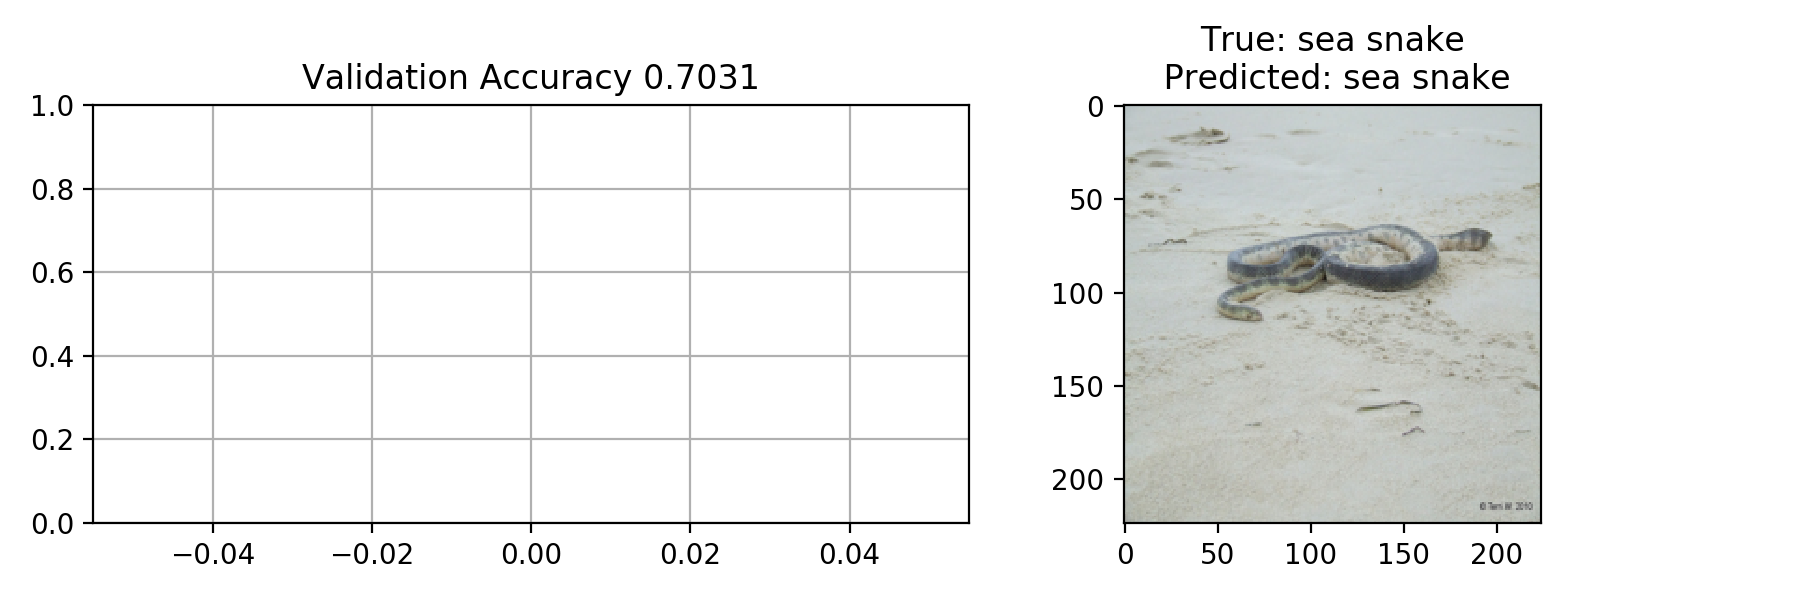

In [16]:
imagenet_validation_grid = PlotGrid(figsize=(9,3))

In [17]:
accuracy = []

imagenet_validation_grid.plot((1, 2, 1), torch.tensor(accuracy), title='Validation Accuracy', filled=False, ylim=(0,1))

for index, batch in enumerate(imagenet_val_loader):
    output = resnet50(batch[1].to(device))
    _, predicted_class = output.topk(1, 1, True, True)
    predicted_descriptions = [ imagenet_val_dataset.descriptions[x] for x in predicted_class.squeeze() ]
    batch_accuracy = accuracy_score(batch[2], predicted_class.cpu().squeeze())
    accuracy.append(batch_accuracy)
    imagenet_validation_grid.plot((1, 2, 1), torch.tensor(accuracy), title='Validation Accuracy {0:.4f}'.format(np.mean(accuracy)))
    imagenet_validation_grid.plot((1, 2, 2), toImage(batch[1][0]), title='True: {}\n Predicted: {}'.format(batch[3][0], predicted_descriptions[0]))
    break

<IPython.core.display.Javascript object>


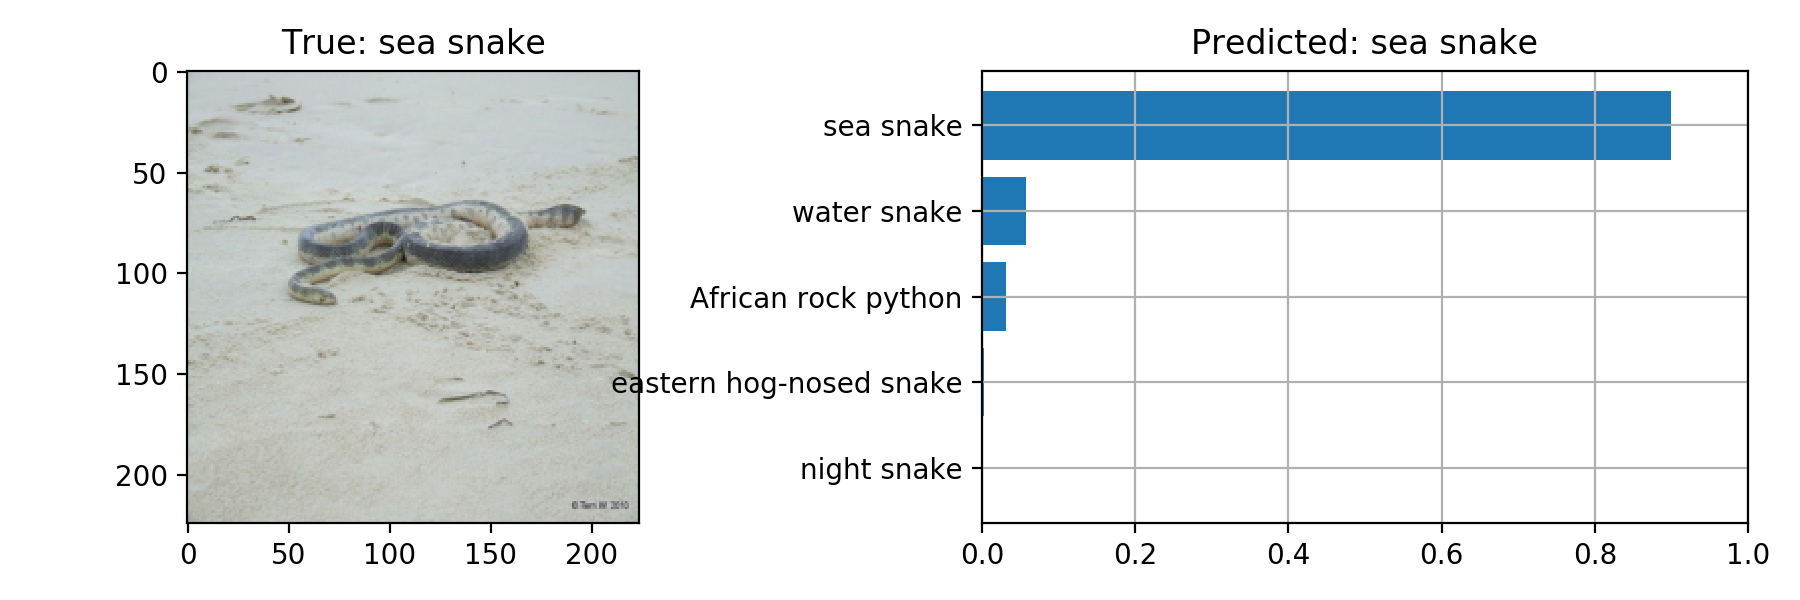

In [18]:
prediction_grid = PlotGrid(figsize=(9,3))

In [19]:
predict(resnet50, imagenet_val_dataset, 0, prediction_grid, (1, 2, 1));

#### Define Hook and Hooker Function

In [ ]:
def assign_plot_index(name, index, normalize, plot=False):
    def print_output(self, input, output):
        data = output.data.squeeze()
        if self.__class__.__name__ != 'Linear':
            data = data.norm(dim=(1, 2))
        if normalize:
            data = data.unsqueeze(0)
            data = data.renorm(1, 0, 1)
            data = data.squeeze()
        data = data.cpu().numpy()
        
        # value
        activations[name] = data
        
        # plot
        if plot:
            plt.subplot(*index)
            plt.plot(data)
            plt.fill_between(range(len(data)), data)
            plt.grid(True)
            plt.title(name)
    return print_output


#### add hooks to model

In [ ]:
def add_hooks(model, hooker, nrows=2, ncols=2, normalize=False):
    names = {}
    for name, param in model.named_parameters():
        name = name.split('.')
        name.pop()
        name = '.'.join(name)
        names[name] = None

    names = list(names)
    for index, name in enumerate(names):
        module = rgetattr(model, name)
        module.register_forward_hook(hooker(name, (nrows, ncols, index + 1), normalize))

# add hooks to resnet50
add_hooks(resnet50, assign_plot_index, nrows=54)

### Create/Load Activations

In [20]:
values_directory = os.path.join('results', 'activation-values')

# for imagenet_val_index, datapoint in enumerate(imagenet_val_dataset):
#     activations = {}
#     predicted_class, prediction_description = predict(resnet50, imagenet_val_dataset, imagenet_val_index, None, None)
#     true_class = datapoint[2]
#     values_path = os.path.join(values_directory, '{}-{}-{}.pickle'.format(imagenet_val_index, true_class, predicted_class))
#     pickle.dump(activations, open(values_path, 'wb'))

def get_sort_key(name):
    return int(name.split('/')[-1].split('.')[0].split('-')[0])

activations_file_list = sorted(
    [os.path.join(values_directory, file) for file in listdir(values_directory)],
    key=get_sort_key
)

In [21]:
def plot_activations(activations, imagenet_val_index, true_class, predicted_class):
    activation_grid = PlotGrid(figsize=(9,90))
    for index, name in enumerate(activations):
        data = activations[name]
        activation_grid.plot((54, 2, index+1), data, title=name)

    # plot image
    activation_grid.plot(
        (54, 2, 108),
        toImage(imagenet_val_dataset[imagenet_val_index][1]),
        title='True: {}\n Predicted: {}'.format(
            imagenet_val_dataset.descriptions[predicted_class],
            imagenet_val_dataset.descriptions[true_class]
        )
    )

    # save figure
    activation_grid.savefig('{}-{}-{}.png'.format(imagenet_val_index, true_class, predicted_class))


def load_activations(activation_file_index):
    activations_file_path = activations_file_list[activation_file_index]
    imagenet_val_index, true_class, predicted_class = activations_file_list[activation_file_index].split('/')[-1].split('.')[0].split('-')
    return pickle.load(open(activations_file_path, 'rb')), int(imagenet_val_index), int(true_class), int(predicted_class)



In [22]:
for index, name in enumerate(activations_file_list):
    activations, imagenet_val_index, true_class, predicted_class = load_activations(index)
#     plot_activations(activations, imagenet_val_index, true_class, predicted_class)
    break


## Jensen-Shannon Divergence

In [23]:
def JSDiv(p, q):
    return torch.nn.KLDivLoss(reduction='sum')(p.log(), q) + torch.nn.KLDivLoss(reduction='sum')(q.log(), p)

# test inputs
p = torch.FloatTensor([0.3, 0.6, 0.1])
q = torch.FloatTensor([0.4, 0.5, 0.1])

# test call
print('{0:.4f} JS Divergence'.format(JSDiv(p, q).item()))

0.0470 JS Divergence


#### Test on activations

In [24]:
def get_layer_activation(activations, layer_name):
    data = torch.from_numpy(activations[layer_name])
    if layer_name == 'fc':
        data = torch.nn.Softmax(dim=0)(data)
    else:
        data = data.unsqueeze(0)
        data = data.renorm(1, 0, 1)
        data = data.squeeze()
    return data


In [25]:
activations_1, _, _, _ = load_activations(1)
activations_2, _, _, _ = load_activations(2)

layer_names = list(activations_2.keys())
regex = re.compile(r'conv1|fc')
layer_names = list(filter(regex.search, layer_names))
layer_indices = [0, 1, 4, 8, 14, 17]
layer_names = [layer_names[i] for i in layer_indices]
layer_index = -2

p = get_layer_activation(activations_1, layer_names[layer_index])
q = get_layer_activation(activations_2, layer_names[layer_index])

assert np.isclose(p.sum().item(), 1), 'activations (p) is not a distribution'
assert np.isclose(q.sum().item(), 1), 'activations (q) is not a distribution'

print('{0:.4f} JS Divergence of activations at layer "{1}"'.format(JSDiv(q, p).item(), layer_names[layer_index]))

0.0462 JS Divergence of activations at layer "layer4.0.conv1"


#### Calculate divergence for multiple images given a reference image

In [26]:
def activation_divergence(target_index, compare_indices, layer_name):
    activations, imagenet_val_index, true_class, predicted_class = load_activations(target_index)
    p = get_layer_activation(activations, layer_name)
    divergence_information = []
    for compare_index in compare_indices:
        activations_, imagenet_val_index_, true_class_, predicted_class_  = load_activations(compare_index)
        q = get_layer_activation(activations_, layer_name)
        divergence_information.append((
            JSDiv(p, q).item(),
            true_class==true_class_,
            predicted_class==predicted_class_,
            true_class==predicted_class,
            imagenet_val_index,
            imagenet_val_index_
        ))
    return divergence_information


In [27]:
divergence_values_directory = os.path.join('results', 'divergence-values')
os.makedirs(divergence_values_directory, exist_ok=True)

divergence_figure_directory = os.path.join('results', 'divergence-plots')
os.makedirs(divergence_figure_directory, exist_ok=True)

def get_sort_key(name):
    return int(name.split('/')[-1].split('.')[0].split('-')[1])

divergences_file_list = sorted(
    [os.path.join(divergence_values_directory, file) for file in listdir(divergence_values_directory)],
    key=get_sort_key
)

#### Calculate/Plot activation divergence at specified layers given the reference image over the validation set

In [28]:
def calculate_divergences(datapoint_index, save=True):
    other_indices = list(range(0, len(imagenet_val_dataset)))
    other_indices.remove(datapoint_index)
    divergence_information = {}
    for index, layer_name in enumerate(layer_names, 1):
        divergence_information[layer_name] = activation_divergence(datapoint_index, other_indices, layer_name)
    if save:
        values_path = os.path.join(divergence_values_directory, 'divergence-{}.pickle'.format(datapoint_index))
        pickle.dump(divergence_information, open(values_path, 'wb'))
    return divergence_information


def load_divergences(divergences_file_index):
    divergences_file_path = divergences_file_list[divergences_file_index]
    _, imagenet_val_index = divergences_file_list[divergences_file_index].split('/')[-1].split('.')[0].split('-')
    return pickle.load(open(divergences_file_path, 'rb')), int(imagenet_val_index)


def plot_divergences(divergence_information, datapoint_index, cols=2, same_class_size=100, other_class_size=1, save=True):
    for index, layer_name in enumerate(layer_names, 1):
        divergences = [ x[0] for x in divergence_information[layer_name] ]
        class_matches = [ int(x[1]) for x in divergence_information[layer_name] ]
        class_matches_size = [ same_class_size if x==1 else other_class_size for x in class_matches ]
        plt.subplot(len(layer_names)//cols + len(layer_names)%cols, cols, index)
        plt.scatter(range(len(divergences)), divergences, s=class_matches_size, c=class_matches)
        plt.title(layer_name)
        plt.show()
    if save:
        plt.savefig(os.path.join(divergence_figure_directory, 'divergence-{}.png'.format(datapoint_index)), bbox_inches='tight')


#### Calculate Min/Mean/Max Divergence

In [29]:
def remove_zeros(array):
    return array[np.flatnonzero(array)]

def calculate_divergence_metrics(divergence_information):
    metrics = {}
    for index, layer_name in enumerate(layer_names, 1):
        divergences = np.array([ x[0] for x in divergence_information[layer_name] ])
        class_matches = np.array([ int(x[1]) for x in divergence_information[layer_name] ])
        other_class = (class_matches + 1) % 2
        class_divergences = remove_zeros(divergences * class_matches)
        other_divergences = remove_zeros(divergences * other_class)
        metrics[layer_name] = {
            'same': {
                'min': class_divergences.min(),
                'mean': class_divergences.mean(),
                'max': class_divergences.max()
            },
            'other': {
                'min': other_divergences.min(),
                'mean': other_divergences.mean(),
                'max': other_divergences.max()
            }
        }
    return metrics


#### Calculate activation divergences

In [ ]:
divergence_metrics = {}

for datapoint_index in range(len(imagenet_val_dataset)):
    divergence_information = calculate_divergences(datapoint_index)
    divergence_metrics[datapoint_index] = calculate_divergence_metrics(divergence_information)

metrics_path = os.path.join(divergence_values_directory, 'divergence-metrics.pickle')
pickle.dump(divergence_metrics, open(metrics_path, 'wb'))

#### Plot activation divergences

In [ ]:
plt.figure(figsize=(9, len(layer_names) * 2))
for index, name in enumerate(divergences_file_list):
    divergence_information, imagenet_val_index = load_divergences(index)
    plot_divergences(divergence_information, imagenet_val_index)
